<font color='red'> **08c** </font> ... <font color='blue'> **structure** </font> https://doi.org/10.1111/gwat.13327

In [8]:
import os; import sys; import flopy ; import matplotlib.pyplot as plt ; import numpy as np; from flopy.plot import styles 
from flopy.utils.geometry import LineString, Polygon ; from pathlib import Path ; sim_ws = Path("./08c") ; sim_ws.mkdir(exist_ok=True)  

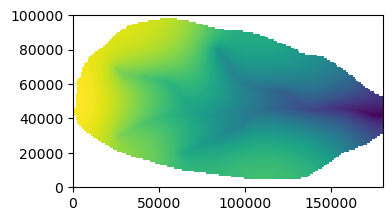

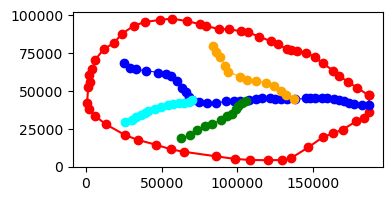

In [30]:
ascii_file = Path("E:/15_REPOS/00_BETAMI/bin/Flopy_3099/fine_topo.asc")   ; fine_topo = flopy.utils.Raster.load(ascii_file)  
Lx = 180000 ; Ly = 100000  ; extent = (0, Lx, 0, Ly)  ; levels = np.arange(10, 110, 10) ; vmin, vmax = 0.0, 100.0
sys.path.append("E:/15_REPOS/00_BETAMI/bin/Flopy_functions")

from notebook_utils_beta_1 import geometries, string2geom
boundary_polygon = string2geom(geometries["boundary"])  ; boundary_polygon.append(boundary_polygon[0])  ; bp = np.array(boundary_polygon)
segs = [string2geom(geometries[f"streamseg{i}"]) for i in range(1, 5)]

fig = plt.figure(figsize=(4,4)); fine_topo.plot()

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot() ; ax.set_aspect("equal") ; riv_colors = ("blue", "cyan", "green", "orange", "red") ; ax.plot(bp[:,0], bp[:,1], "ro-")
for idx, seg in enumerate(segs):     sa = np.array(seg) ; ax.plot(sa[:, 0], sa[:, 1], color=riv_colors[idx], lw=0.75, marker="o")

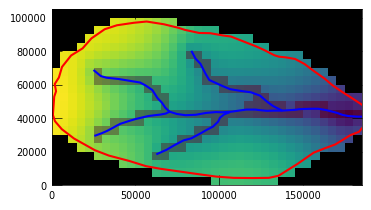

In [ ]:
dx = dy = 5000 ; dv0 = 5.0     ; nlay = 1 ; nrow = int(Ly / dy) + 1   ; ncol = int(Lx / dx) + 1
delr = np.array(ncol * [dx])   ; delc = np.array(nrow * [dy])         ; top=np.ones((nrow,ncol))*1000.0    ; botm=np.ones((nlay,nrow,ncol))*-100.0

modelgrid = flopy.discretization.StructuredGrid(nlay=nlay, delr=delr, delc=delc, xoff=0, yoff=0, top=top, botm=botm)
new_top   = fine_topo.resample_to_grid(modelgrid, band=fine_topo.bands[0], method="min", extrapolate_edges=True)

ix = flopy.utils.GridIntersect(modelgrid, method="vertex", rtree=True)                 ; result = ix.intersect(Polygon(boundary_polygon))
idxs = tuple(zip(*result.cellids))      ; idomain = np.zeros((nrow, ncol), dtype=int)  ; idomain[idxs] = 1
modelgrid._idomain = idomain            ; modelgrid._top = new_top

ixs = flopy.utils.GridIntersect(modelgrid, method="vertex")   ; cellids = []
for seg in segs: v = ixs.intersect(LineString(seg), sort_by_cellid=True)               ; cellids += v["cellids"].tolist()
intersection_rg = np.zeros(modelgrid.shape[1:])
for loc in cellids:     intersection_rg[loc] = 1

with styles.USGSMap():
    fig, ax = plt.subplots(figsize=(4, 4))
    pmv = flopy.plot.PlotMapView(modelgrid=modelgrid) ; ax.set_aspect("equal") ; pmv.plot_array(modelgrid.top)
    pmv.plot_array(intersection_rg,masked_values=[0,],alpha=0.2,cmap="Reds_r") ; pmv.plot_inactive() ; ax.plot(bp[:, 0], bp[:, 1], "r-")
    for seg in segs: sa = np.array(seg)  ; ax.plot(sa[:, 0], sa[:, 1], "b-")

In [ ]:
nlay = 2; ixs = flopy.utils.GridIntersect(modelgrid, method="vertex")                                          ; drn_cellids = [] ; drn_lengths = []
for seg in segs: v=ixs.intersect(LineString(seg), sort_by_cellid=True) ; drn_cellids += v["cellids"].tolist()  ;drn_lengths += v["lengths"].tolist()

leakance = 1.0 / (0.5 * dv0)  ; drn_data = []       # kv / b
for (r, c), length in zip(drn_cellids, drn_lengths):
    x = modelgrid.xcellcenters[r, c]          ; width = 5.0 + (14.0 / Lx) * (Lx - x)
    conductance = leakance * length * width                                               ; drn_data.append((0,r,c,modelgrid.top[r,c], conductance))

idomain = modelgrid.idomain.copy()  ; index = tuple(zip(*drn_cellids))  ; idomain[index] = -1      ; gw_discharge_data = []
for r in range(nrow):
    for c in range(ncol):
        if idomain[r, c] < 1:
            continue
        conductance = leakance * dx * dy                                  ; gw_discharge_data.append((0,r,c,modelgrid.top[r,c]-0.5,conductance,1.0))

botm = np.zeros((nlay, nrow, ncol))   ; botm[0] = modelgrid.top - dv0
for ix in range(1, nlay):               dv0 *= 1.5                                                                   ; botm[ix] = botm[ix - 1] - dv0

idomain = np.zeros((nlay, nrow, ncol), dtype=int)  ; idomain[:] = modelgrid.idomain ; strt = np.zeros((nlay, nrow, ncol))     ;strt[:]=modelgrid.top

In [ ]:
sim = flopy.mf6.MFSimulation(sim_name="basin",sim_ws=sim_ws,exe_name="mf6")
flopy.mf6.ModflowTdis(sim)
flopy.mf6.ModflowIms(sim,complexity="simple",print_option="SUMMARY",linear_acceleration="bicgstab",outer_maximum=1000,
                           inner_maximum=100,outer_dvclose=1e-5,inner_dvclose=1e-6)
gwf = flopy.mf6.ModflowGwf (sim,save_flows=True,newtonoptions="NEWTON UNDER_RELAXATION")
flopy.mf6.ModflowGwfdis(gwf,nlay=nlay,nrow=nrow,ncol=ncol,delr=dx,delc=dy,idomain=idomain,top=modelgrid.top,botm=botm,xorigin=0.0,yorigin=0.0)
ic = flopy.mf6.ModflowGwfic(gwf, strt=strt)
flopy.mf6.ModflowGwfnpf (gwf,save_specific_discharge=True,icelltype=1,k=1.0)
flopy.mf6.ModflowGwfsto (gwf,iconvert=1,ss=1e-5,sy=0.2,steady_state=True,)
flopy.mf6.ModflowGwfrcha(gwf,recharge=0.000001)
flopy.mf6.ModflowGwfdrn (gwf,stress_period_data=drn_data,pname="river")                                                    # See
flopy.mf6.ModflowGwfdrn (gwf,auxiliary=["depth"],auxdepthname="depth",stress_period_data=gw_discharge_data,pname="gwd")    # See
oc = flopy.mf6.ModflowGwfoc(gwf,head_filerecord=f"{gwf.name}.hds",budget_filerecord=f"{gwf.name}.cbc",saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
                            printrecord=[("BUDGET", "ALL")])
sim.write_simulation(silent=True)    ; sim.run_simulation(silent=True) 

In [24]:
water_table = flopy.utils.postprocessing.get_water_table(gwf.output.head().get_data())
heads = gwf.output.head().get_data()  ; hmin, hmax = water_table.min(), water_table.max()  ; contours = np.arange(0, 100, 10)  ; hmin, hmax

(1.1351828297118696, 105.96803703036794)

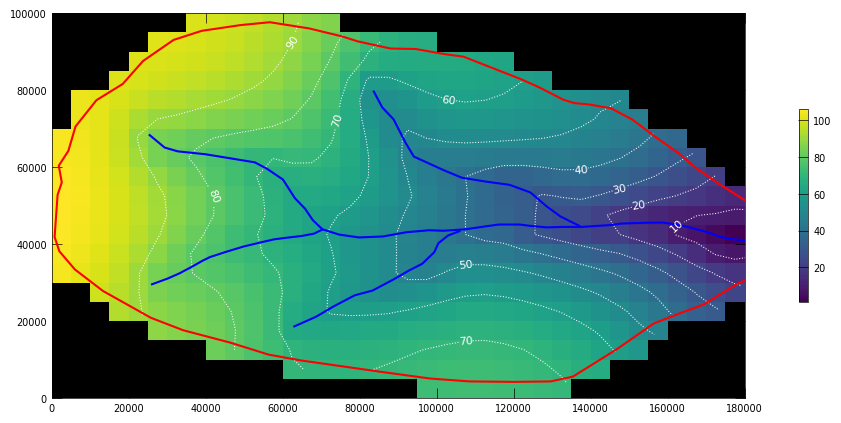

In [26]:
with styles.USGSMap():
    fig = plt.figure(figsize=(14, 5))
    ax = fig.add_subplot()  ; ax.set_xlim(0, Lx) ; ax.set_ylim(0, Ly) ; ax.set_aspect("equal")
    pmv = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid, ax=ax)  ; h = pmv.plot_array(heads, vmin=hmin, vmax=hmax)
    c = pmv.contour_array(water_table,levels=contours,colors="white",linewidths=0.75,linestyles=":")
    plt.clabel(c, fontsize=8) ; pmv.plot_inactive() ; plt.colorbar(h, ax=ax, shrink=0.5) ; ax.plot(bp[:, 0], bp[:, 1], "r-")
    for seg in segs: sa = np.array(seg)  ; ax.plot(sa[:, 0], sa[:, 1], "b-")